In [53]:
!nvidia-smi


Wed Feb 25 23:43:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:01:00.0 Off |                   On |
| N/A   34C    P0             94W /  400W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [3]:

import numpy as np, pandas as pd
# ---------------- Data Loading ----------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# ---------------- Physics feature engineering ----------------
M_p = 938.272088; M_n = 939.565420; epsilon=1e-30; LN10=np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values

mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu_MeVc2+epsilon),0,np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"],1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"],1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."],1e-30,np.inf))

log10_exp_term = (2*np.pi*df["eta"])/LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

# ---------------- 29 training features ----------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]




Min Q2n: -14.71
Max Q2n: 7.83
Mean Q2n: -0.41822480181200433


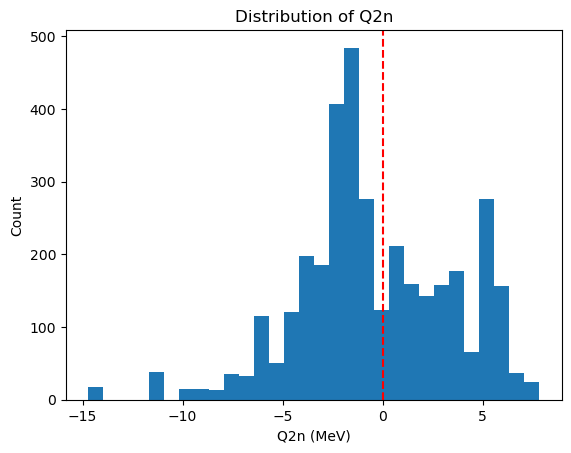

In [4]:
import numpy as np
import matplotlib.pyplot as plt

q2n = df["Q ( 2 n )"].values  # replace with your actual column name

print("Min Q2n:", np.min(q2n))
print("Max Q2n:", np.max(q2n))
print("Mean Q2n:", np.mean(q2n))

plt.hist(q2n, bins=30)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Q2n (MeV)")
plt.ylabel("Count")
plt.title("Distribution of Q2n")
plt.show()

Min beta2: -0.478
Max beta2: 0.366
Mean beta2: -0.04771574178935447


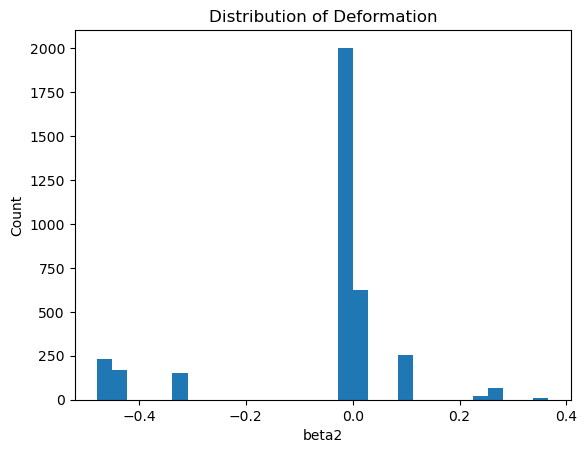

In [5]:
beta2 = df["β T"].values
beta2 = df["β P"].values
print("Min beta2:", np.min(beta2))
print("Max beta2:", np.max(beta2))
print("Mean beta2:", np.mean(beta2))

plt.hist(beta2, bins=30)
plt.xlabel("beta2")
plt.ylabel("Count")
plt.title("Distribution of Deformation")
plt.show()

Min Z1Z2: 160
Max Z1Z2: 1640


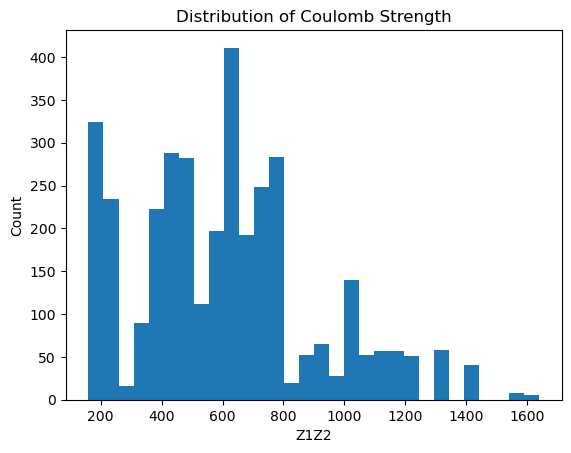

In [6]:
Z1 = df["Z1"]
Z2 = df["Z2"]

Z1Z2 = Z1 * Z2
df['Z1Z2']=Z1Z2
print("Min Z1Z2:", np.min(Z1Z2))
print("Max Z1Z2:", np.max(Z1Z2))

plt.hist(Z1Z2, bins=30)
plt.xlabel("Z1Z2")
plt.ylabel("Count")
plt.title("Distribution of Coulomb Strength")
plt.show()

In [7]:
df["Q_group"] = np.where(df["Q ( 2 n )"] > 0, "positive", "negative")
df["def_group"] = np.where(abs(df["β P"]) + abs(df["β P"]) > 0.25, "deformed", "spherical")
df["Z_group"] = pd.qcut(df["Z1Z2"], 3, labels=["light","medium","heavy"])

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load your full-data components
seed_dir = "mdn_70_10_20_optimized/ensembles_fast/seed_42"
data = np.load(seed_dir + "/mdn_all_components.npz")

pi = data["pi"]        # shape (N_total, 5)
mu = data["mu"]
sigma = data["sigma"]

print(pi.shape)

(3532, 5)


In [9]:
C = 1 - np.sum(pi**2, axis=1)

In [10]:
df_full = df.copy()
df_full["C"] = C

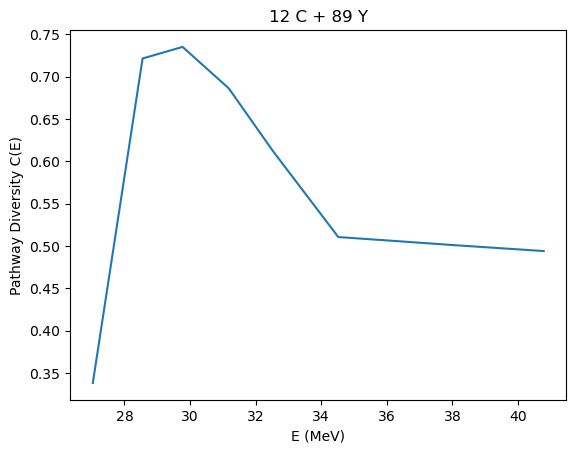

In [11]:
reaction_name = df_full["Reaction"].unique()[0]
sub = df_full[df_full["Reaction"] == reaction_name]

plt.plot(sub["E c.m."], sub["C"])
plt.xlabel("E (MeV)")
plt.ylabel("Pathway Diversity C(E)")
plt.title(reaction_name)
plt.show()

In [12]:
eps = 1e-12

H_mix = -np.sum(pi * np.log(pi + eps), axis=1)

H_var = 0.5 * np.sum(
    pi * np.log(2*np.pi*np.e * sigma**2 + eps),
    axis=1
)

S = H_mix + H_var
S
df_full["Entropy"] = S

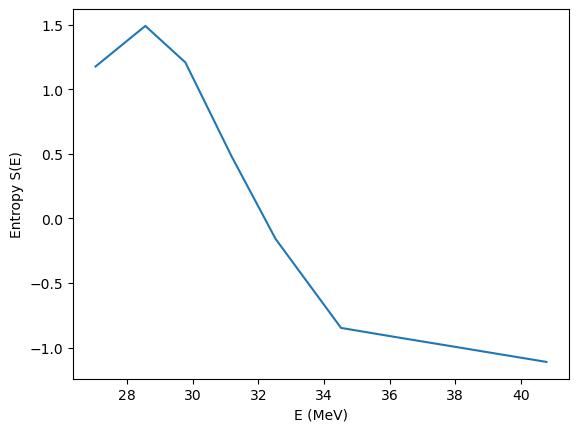

In [13]:
reaction_name = df_full["Reaction"].unique()[0]

sub = df_full[df_full["Reaction"] == reaction_name].sort_values("E c.m.")

plt.plot(sub["E c.m."], sub["Entropy"])
plt.xlabel("E (MeV)")
plt.ylabel("Entropy S(E)")
plt.show()

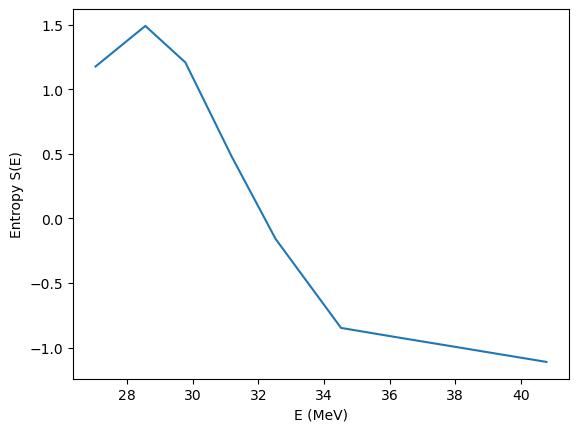

In [14]:
plt.plot(sub["E c.m."], sub["Entropy"])
plt.xlabel("E (MeV)")
plt.ylabel("Entropy S(E)")
plt.show()

In [15]:
results = []

for reaction in df_full["Reaction"].unique():
    sub = df_full[df_full["Reaction"] == reaction].sort_values("E c.m.")
    
    if len(sub) < 5:
        continue
    
    idx_peak = np.argmax(sub["C"].values)
    E_peak = sub["E c.m."].values[idx_peak]
    
    results.append({
        "Reaction": reaction,
        "E_peak": E_peak
    })

results_df = pd.DataFrame(results)

In [16]:
structure = df.groupby("Reaction").first().reset_index()

merged = results_df.merge(
    structure[["Reaction","Q ( 2 n )","β P","β T","Z1Z2_over_Ecm"]],
    on="Reaction"
)

merged["beta_eff"] = abs(merged["β P"]) + abs(merged["β T"])

In [17]:
print(merged.corr(numeric_only=True))

                 E_peak  Q ( 2 n )       β P       β T  Z1Z2_over_Ecm  \
E_peak         1.000000   0.473436  0.072427 -0.188355       0.709841   
Q ( 2 n )      0.473436   1.000000 -0.027336  0.053812       0.508942   
β P            0.072427  -0.027336  1.000000  0.016283      -0.029601   
β T           -0.188355   0.053812  0.016283  1.000000      -0.078254   
Z1Z2_over_Ecm  0.709841   0.508942 -0.029601 -0.078254       1.000000   
beta_eff      -0.285993  -0.072339 -0.670161  0.440415      -0.118142   

               beta_eff  
E_peak        -0.285993  
Q ( 2 n )     -0.072339  
β P           -0.670161  
β T            0.440415  
Z1Z2_over_Ecm -0.118142  
beta_eff       1.000000  


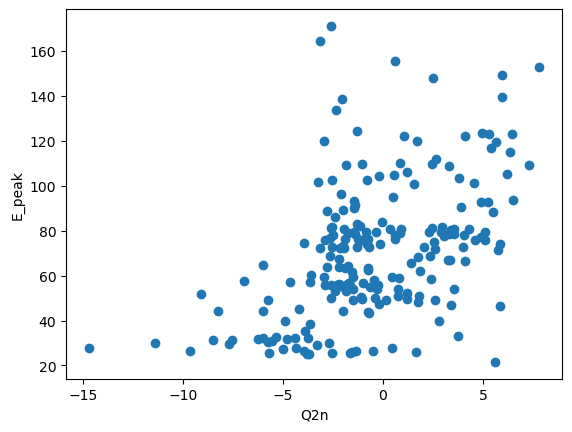

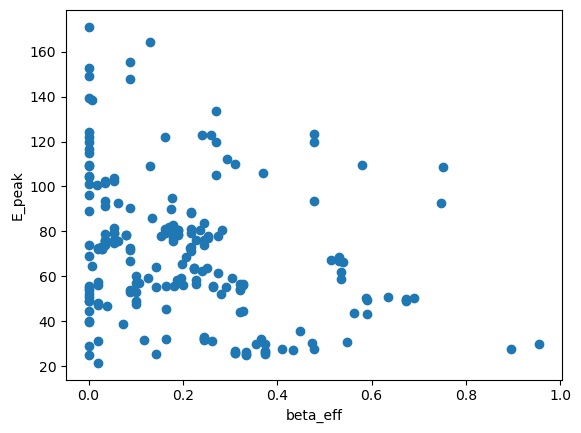

In [18]:
plt.scatter(merged["Q ( 2 n )"], merged["E_peak"])
plt.xlabel("Q2n")
plt.ylabel("E_peak")
plt.show()

plt.scatter(merged["beta_eff"], merged["E_peak"])
plt.xlabel("beta_eff")
plt.ylabel("E_peak")
plt.show()

In [19]:
merged["Z1Z2"] = structure["Z1"] * structure["Z2"]

In [20]:
# Get one row per reaction
barrier_df = df.groupby("Reaction").first().reset_index()

# Compute Z1Z2
barrier_df["Z1Z2"] = barrier_df["Z1"] * barrier_df["Z2"]

# Compute Coulomb barrier height
barrier_df["V_B"] = (barrier_df["Z1Z2"] * 1.44) / barrier_df["R B"]

barrier_df[["Reaction","V_B"]].head()

,Reaction,V_B
0,12 C + 144 Sm,48.259459
1,12 C + 152 Sm,43.728980
2,12 C + 154 Sm,43.200000
3,12 C + 181 Ta,49.584906
4,12 C + 194 Pt,57.797599


In [21]:
results_df  # contains Reaction and E_peak

,Reaction,E_peak
0,12 C + 89 Y,29.774
1,12 C + 92 Zr,29.980
2,12 C + 144 Sm,44.210
3,12 C + 152 Sm,43.750
4,12 C + 154 Sm,43.320
...,...,...
204,124 Sn + 48 Ca,119.797
205,132 Sn + 48 Ca,109.697
206,132 Sn + 58 Ni,152.568
207,132 Sn + 64 Ni,147.969


In [22]:
merged_norm = results_df.merge(
    barrier_df[["Reaction","V_B","Q ( 2 n )","β P","β T","Z1Z2"]],
    on="Reaction"
)

merged_norm["beta_eff"] = abs(merged_norm["β P"]) + abs(merged_norm["β T"])

In [23]:
merged_norm["DeltaE"] = merged_norm["E_peak"] - merged_norm["V_B"]

In [24]:
merged_norm["E_ratio"] = merged_norm["E_peak"] / merged_norm["V_B"]  
#either this or above should be used for normalization

In [25]:
print(merged_norm[[
    "DeltaE",
    "E_ratio",
    "Q ( 2 n )",
    "beta_eff",
    "Z1Z2"
]].corr())

             DeltaE   E_ratio  Q ( 2 n )  beta_eff      Z1Z2
DeltaE     1.000000  0.818725  -0.394608  0.559578 -0.706717
E_ratio    0.818725  1.000000  -0.262686  0.608884 -0.291614
Q ( 2 n ) -0.394608 -0.262686   1.000000 -0.072339  0.482087
beta_eff   0.559578  0.608884  -0.072339  1.000000 -0.259438
Z1Z2      -0.706717 -0.291614   0.482087 -0.259438  1.000000


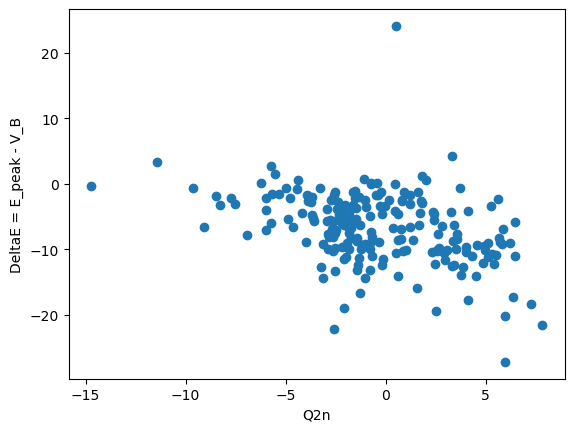

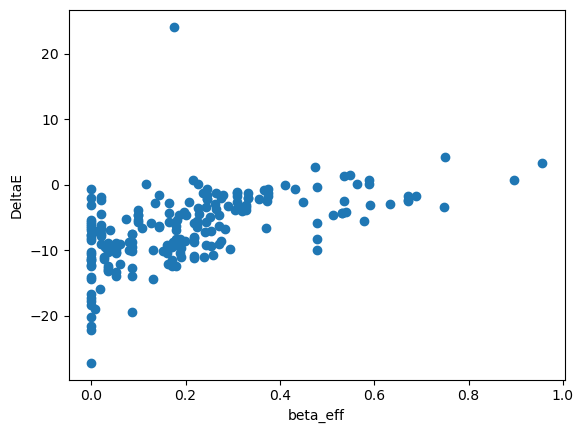

In [26]:
import matplotlib.pyplot as plt

plt.scatter(merged_norm["Q ( 2 n )"], merged_norm["DeltaE"])
plt.xlabel("Q2n")
plt.ylabel("DeltaE = E_peak - V_B")
plt.show()

plt.scatter(merged_norm["beta_eff"], merged_norm["DeltaE"])
plt.xlabel("beta_eff")
plt.ylabel("DeltaE")
plt.show()

In [27]:
import numpy as np
import pandas as pd
import os

# ---- Load components from one seed ----
seed_dir = "mdn_70_10_20_optimized/ensembles_fast/seed_42"
data = np.load(os.path.join(seed_dir, "mdn_all_components.npz"))

pi_all = data["pi"]   # shape: (N_all, K)

print("pi shape:", pi_all.shape)

pi shape: (3532, 5)


In [28]:
df_full = df.copy().reset_index(drop=True)

# Add component weights
K = pi_all.shape[1]
for k in range(K):
    df_full[f"pi_{k}"] = pi_all[:, k]

In [29]:
df_full["dominant"] = np.argmax(pi_all, axis=1)

In [30]:
switch_results = []

for reaction, sub in df_full.groupby("Reaction"):
    
    sub = sub.sort_values("E c.m.").reset_index(drop=True)
    
    dom = sub["dominant"].values
    E_vals = sub["E c.m."].values
    
    switch_energy = None
    
    for i in range(1, len(dom)):
        if dom[i] != dom[i-1]:
            switch_energy = E_vals[i]
            break
    
    # If no switch found
    if switch_energy is None:
        switch_energy = np.nan
    
    switch_results.append({
        "Reaction": reaction,
        "E_switch": switch_energy
    })

switch_df = pd.DataFrame(switch_results)

print(switch_df.head(15))

          Reaction  E_switch
0    12 C + 144 Sm    43.760
1    12 C + 152 Sm       NaN
2    12 C + 154 Sm    44.250
3    12 C + 181 Ta       NaN
4    12 C + 194 Pt    54.150
5    12 C + 198 Pt    54.210
6    12 C + 204 Pb    56.239
7    12 C + 206 Pb    56.507
8    12 C + 208 Pb    56.490
9    12 C + 237 Np    57.900
10    12 C + 238 U    65.780
11     12 C + 89 Y    28.554
12    12 C + 92 Zr    29.090
13  124 Sn + 40 Ca   116.653
14  124 Sn + 48 Ca   119.797


In [31]:
barrier_df = df.groupby("Reaction").first().reset_index()

barrier_df["V_B"] = (barrier_df["Z1"] * barrier_df["Z2"] * 1.44) / barrier_df["R B"]

In [32]:
switch_df = switch_df.merge(
    barrier_df[["Reaction", "V_B", "Q ( 2 n )", "β P", "β T"]],
    on="Reaction"
)

switch_df["beta_eff"] = abs(switch_df["β P"]) + abs(switch_df["β T"])

In [33]:
switch_df["x_switch"] = switch_df["E_switch"] / switch_df["V_B"]
switch_df["Delta_switch"] = switch_df["E_switch"] - switch_df["V_B"]

In [34]:
print(switch_df[["E_switch", "V_B", "x_switch"]].describe())

         E_switch         V_B    x_switch
count  180.000000  213.000000  180.000000
mean    71.177561   77.439462    0.927565
std     30.646198   34.374604    0.052496
min     20.150000   23.925234    0.837655
25%     50.432750   53.752973    0.887410
50%     72.513500   75.789474    0.917484
75%     84.225000   91.576642    0.947817
max    173.710000  193.256956    1.110090


In [35]:
print(switch_df[[
    "x_switch",
    "Q ( 2 n )",
    "beta_eff"
]].corr())

           x_switch  Q ( 2 n )  beta_eff
x_switch   1.000000  -0.325202  0.653720
Q ( 2 n ) -0.325202   1.000000 -0.069956
beta_eff   0.653720  -0.069956  1.000000


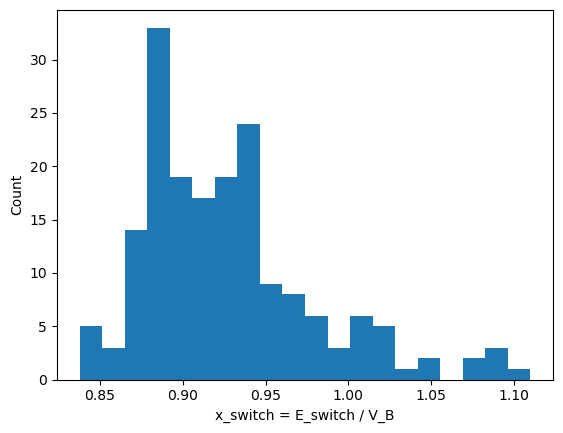

In [36]:
import matplotlib.pyplot as plt
plt.hist(switch_df["x_switch"].dropna(), bins=20)
plt.xlabel("x_switch = E_switch / V_B")
plt.ylabel("Count")
plt.show()

In [37]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Drop NaNs
reg_df = switch_df.dropna(subset=["x_switch", "beta_eff", "Q ( 2 n )"]).copy()

X = reg_df[["beta_eff", "Q ( 2 n )"]].values
y = reg_df["x_switch"].values

In [38]:
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)

print("Intercept:", model.intercept_)
print("Coefficients [beta_eff, Q2n]:", model.coef_)
print("R²:", r2)

Intercept: 0.8896780160861322
Coefficients [beta_eff, Q2n]: [ 0.18452781 -0.00391087]
R²: 0.5040604502633994


In [39]:
import random

# Shuffle structural variables
shuffled = reg_df.copy()

shuffled["beta_eff"] = np.random.permutation(shuffled["beta_eff"].values)
shuffled["Q ( 2 n )"] = np.random.permutation(shuffled["Q ( 2 n )"].values)

X_shuff = shuffled[["beta_eff", "Q ( 2 n )"]].values
y_shuff = shuffled["x_switch"].values

In [40]:
model_shuff = LinearRegression()
model_shuff.fit(X_shuff, y_shuff)

y_pred_shuff = model_shuff.predict(X_shuff)

r2_shuff = r2_score(y_shuff, y_pred_shuff)

print("Shuffled R²:", r2_shuff)

Shuffled R²: 0.03081392319997789


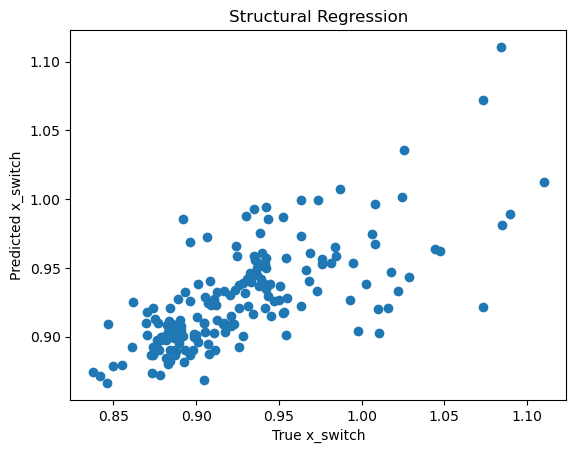

In [41]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred)
plt.xlabel("True x_switch")
plt.ylabel("Predicted x_switch")
plt.title("Structural Regression")
plt.show()

In [42]:
import numpy as np
import pandas as pd
import os

SEEDS = [42 + i for i in range(10)]
base_dir = "mdn_70_10_20_optimized/ensembles_fast"

# dictionary: reaction -> list of x_switch values
switch_seed_dict = {}

for s in SEEDS:
    
    seed_dir = os.path.join(base_dir, f"seed_{s}")
    data = np.load(os.path.join(seed_dir, "mdn_all_components.npz"))
    
    pi_all = data["pi"]
    
    df_temp = df.copy().reset_index(drop=True)
    df_temp["dominant"] = np.argmax(pi_all, axis=1)
    
    # compute switch per reaction
    for reaction, sub in df_temp.groupby("Reaction"):
        
        sub = sub.sort_values("E c.m.").reset_index(drop=True)
        dom = sub["dominant"].values
        E_vals = sub["E c.m."].values
        
        switch_energy = np.nan
        
        for i in range(1, len(dom)):
            if dom[i] != dom[i-1]:
                switch_energy = E_vals[i]
                break
        
        if not np.isnan(switch_energy):
            
            # compute barrier height
            row = barrier_df[barrier_df["Reaction"] == reaction].iloc[0]
            V_B = row["V_B"]
            
            x_switch = switch_energy / V_B
            
            if reaction not in switch_seed_dict:
                switch_seed_dict[reaction] = []
            
            switch_seed_dict[reaction].append(x_switch)

In [43]:
seed_stability = []

for reaction, values in switch_seed_dict.items():
    
    if len(values) == len(SEEDS):  # ensure present in all seeds
        
        mean_x = np.mean(values)
        std_x = np.std(values)
        
        seed_stability.append({
            "Reaction": reaction,
            "mean_x_switch": mean_x,
            "std_seed": std_x
        })

seed_stability_df = pd.DataFrame(seed_stability)

print(seed_stability_df["std_seed"].describe())

count    102.000000
mean       0.014673
std        0.009986
min        0.000000
25%        0.008919
50%        0.011607
75%        0.016763
max        0.062716
Name: std_seed, dtype: float64


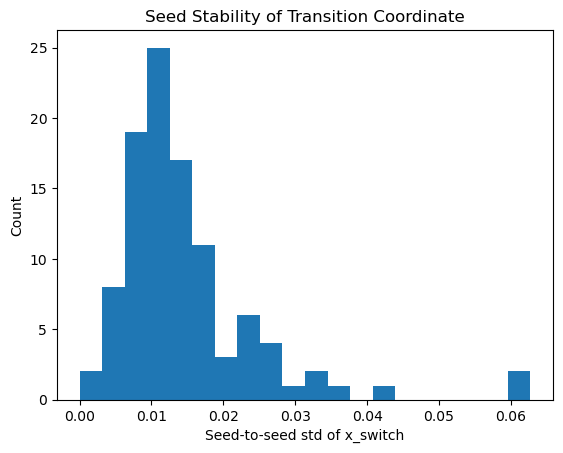

In [44]:
import matplotlib.pyplot as plt

plt.hist(seed_stability_df["std_seed"], bins=20)
plt.xlabel("Seed-to-seed std of x_switch")
plt.ylabel("Count")
plt.title("Seed Stability of Transition Coordinate")
plt.show()

In [45]:
reaction = "16 O + 144 Sm"

sub = df[df["Reaction"] == reaction].copy()
sub = sub.sort_values("E c.m.")

E_vals = sub["E c.m."].values

# Extract x_switch
x_switch = switch_df[switch_df["Reaction"] == reaction]["x_switch"].values[0]

# Get barrier
row = barrier_df[barrier_df["Reaction"] == reaction].iloc[0]
V_B = row["V_B"]

E_switch = x_switch * V_B

print("V_B:", V_B)
print("x_switch:", x_switch)
print("E_switch:", E_switch)

V_B: 65.28702010968922
x_switch: 0.8736805555555555
E_switch: 57.04


In [46]:
# for all seeds
reaction = "16 O + 144 Sm"

x_list = switch_seed_dict[reaction]

print("Mean x_switch:", np.mean(x_list))
print("Std x_switch:", np.std(x_list))

# Convert to energy
V_B = barrier_df[barrier_df["Reaction"] == reaction]["V_B"].iloc[0]

E_list = np.array(x_list) * V_B

print("Mean E_switch:", np.mean(E_list))
print("Std E_switch:", np.std(E_list))

Mean x_switch: 0.8857426775313619
Std x_switch: 0.013235845274962604
Mean E_switch: 57.8275
Std E_switch: 0.8641288966352191


In [48]:
# for all seeds
reaction = "40 Ca + 96 Zr"

x_list = switch_seed_dict[reaction]

print("Mean x_switch:", np.mean(x_list))
print("Std x_switch:", np.std(x_list))

# Convert to energy
V_B = barrier_df[barrier_df["Reaction"] == reaction]["V_B"].iloc[0]

E_list = np.array(x_list) * V_B

print("Mean E_switch:", np.mean(E_list))
print("Std E_switch:", np.std(E_list))

Mean x_switch: 0.8841626736111111
Std x_switch: 0.0030219080144569823
Mean E_switch: 87.57999999999998
Std E_switch: 0.29933259094191483


In [49]:
# check barrier
reaction = "40 Ca + 96 Zr"
row = barrier_df[barrier_df["Reaction"] == reaction].iloc[0]
print("V_B:", row["V_B"])

V_B: 99.05417024935511


In [43]:
import numpy as np
import pandas as pd
import os

seed_dir = "mdn_70_10_20_optimized/ensembles_fast/seed_42"
data = np.load(os.path.join(seed_dir, "mdn_all_components.npz"))
pi_all = data["pi"]

df_temp = df.copy().reset_index(drop=True)
df_temp["dominant"] = np.argmax(pi_all, axis=1)

K = pi_all.shape[1]

width_results = []

for reaction, sub in df_temp.groupby("Reaction"):
    
    sub = sub.sort_values("E c.m.").reset_index(drop=True)
    
    dom = sub["dominant"].values
    E_vals = sub["E c.m."].values
    
    switch_index = None
    
    for i in range(1, len(dom)):
        if dom[i] != dom[i-1]:
            switch_index = i
            break
    
    if switch_index is None:
        continue
    
    dominant_k = dom[switch_index]
    
    pi_dom = pi_all[sub.index, dominant_k]
    
    mask = (pi_dom >= 0.4) & (pi_dom <= 0.6)
    
    if np.sum(mask) >= 2:
        E_transition = E_vals[mask]
        width = np.max(E_transition) - np.min(E_transition)
    else:
        width = np.nan
    
    width_results.append({
        "Reaction": reaction,
        "width": width
    })

width_df = pd.DataFrame(width_results)

In [44]:
width_df = width_df.merge(
    barrier_df[["Reaction", "V_B", "Q ( 2 n )", "β P", "β T"]],
    on="Reaction"
)

width_df["beta_eff"] = abs(width_df["β P"]) + abs(width_df["β T"])
width_df["width_norm"] = width_df["width"] / width_df["V_B"]

In [45]:
print(width_df["width_norm"].describe())

count    101.000000
mean       0.113211
std        0.112431
min        0.000000
25%        0.019261
50%        0.082253
75%        0.179327
max        0.594653
Name: width_norm, dtype: float64


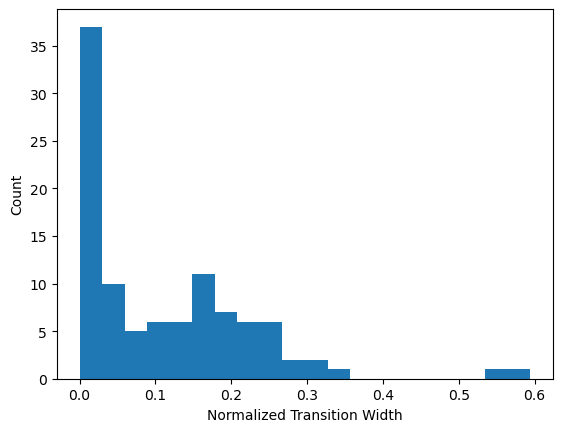

In [46]:
import matplotlib.pyplot as plt
plt.hist(width_df["width_norm"].dropna(), bins=20)
plt.xlabel("Normalized Transition Width")
plt.ylabel("Count")
plt.show()

In [47]:
print(width_df[[
    "width_norm",
    "beta_eff",
    "Q ( 2 n )"
]].corr())

            width_norm  beta_eff  Q ( 2 n )
width_norm    1.000000  0.042654  -0.037302
beta_eff      0.042654  1.000000  -0.074978
Q ( 2 n )    -0.037302 -0.074978   1.000000


In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def wong_sigma(E, V, Rb, hw):
    E = np.array(E, dtype=float)
    
    # avoid division by zero
    E_safe = np.where(E <= 1e-8, 1e-8, E)
    hw_safe = hw if hw > 1e-6 else 1e-6
    
    x = 2*np.pi*(E_safe - V)/hw_safe
    
    # numerically stable log(1 + exp(x))
    log_term = np.where(
        x > 50,
        x,
        np.log1p(np.exp(x))
    )
    
    sigma = (Rb**2 * hw_safe / (2*E_safe)) * log_term
    return sigma

In [49]:
reaction = "12 C + 144 Sm"

sub = df[df["Reaction"] == reaction].copy()
sub = sub.sort_values("E c.m.")

E_vals = sub["E c.m."].values
sigma_exp = sub["σ"].values

# parameters
row = barrier_df[barrier_df["Reaction"] == reaction].iloc[0]
V_B = row["V_B"]
Rb = row["R B"]
hw = row["ħ ω"]

# ML switch
x_switch = switch_df[switch_df["Reaction"] == reaction]["x_switch"].values[0]
V_eff = x_switch * V_B

sigma_wong = wong_sigma(E_vals, V_B, Rb, hw)
sigma_eff  = wong_sigma(E_vals, V_eff, Rb, hw)

In [50]:
from sklearn.metrics import mean_squared_error

rmse_wong = np.sqrt(mean_squared_error(sigma_exp, sigma_wong))
rmse_eff  = np.sqrt(mean_squared_error(sigma_exp, sigma_eff))

print("Standard Wong RMSE:", rmse_wong)
print("ML-shifted Wong RMSE:", rmse_eff)

Standard Wong RMSE: 495.9577903096703
ML-shifted Wong RMSE: 478.75039531998027


In [51]:
results = []

for reaction in switch_df["Reaction"].dropna():
    
    sub = df[df["Reaction"] == reaction].copy()
    sub = sub.sort_values("E c.m.")
    
    E_vals = sub["E c.m."].values
    sigma_exp = sub["σ"].values
    
    if len(E_vals) < 3:
        continue
    
    # Get barrier parameters
    row = barrier_df[barrier_df["Reaction"] == reaction].iloc[0]
    V_B = row["V_B"]
    Rb = row["R B"]
    hw = row["ħ ω"]
    
    # Get ML switch coordinate
    x_switch = switch_df[switch_df["Reaction"] == reaction]["x_switch"].values
    if len(x_switch) == 0:
        continue
    
    V_eff = x_switch[0] * V_B
    
    # Compute cross-sections
    sigma_wong = wong_sigma(E_vals, V_B, Rb, hw)
    sigma_eff  = wong_sigma(E_vals, V_eff, Rb, hw)
    
    # Remove invalid values
    mask = (
        np.isfinite(sigma_exp) &
        np.isfinite(sigma_wong) &
        np.isfinite(sigma_eff)
    )
    
    if np.sum(mask) < 3:
        continue
    
    rmse_wong = np.sqrt(mean_squared_error(
        sigma_exp[mask], sigma_wong[mask]
    ))
    
    rmse_eff = np.sqrt(mean_squared_error(
        sigma_exp[mask], sigma_eff[mask]
    ))
    
    results.append({
        "Reaction": reaction,
        "RMSE_wong": rmse_wong,
        "RMSE_eff": rmse_eff,
        "Improvement": rmse_wong - rmse_eff
    })

results_df = pd.DataFrame(results)

In [52]:
print("Number of reactions evaluated:", len(results_df))

print("Mean improvement:", results_df["Improvement"].mean())

print("Fraction improved:",
      np.mean(results_df["Improvement"] > 0))

print("Median improvement:",
      results_df["Improvement"].median())

Number of reactions evaluated: 180
Mean improvement: 14.993942647596771
Fraction improved: 0.8888888888888888
Median improvement: 16.356113583735088


In [53]:
results_df = results_df.merge(
    switch_df[["Reaction","beta_eff","Q ( 2 n )"]],
    on="Reaction"
)

print(results_df[["Improvement","beta_eff","Q ( 2 n )"]].corr())

             Improvement  beta_eff  Q ( 2 n )
Improvement     1.000000 -0.573467   0.295672
beta_eff       -0.573467  1.000000  -0.074978
Q ( 2 n )       0.295672 -0.074978   1.000000


In [54]:
switch_df["DeltaV"] = switch_df["x_switch"] * switch_df["V_B"] - switch_df["V_B"]

In [55]:
switch_df = switch_df.merge(
    barrier_df[["Reaction","ħ ω"]],
    on="Reaction"
)

In [56]:
print(switch_df[["DeltaV","ħ ω"]].corr())

          DeltaV       ħ ω
DeltaV  1.000000 -0.008065
ħ ω    -0.008065  1.000000


In [57]:
switch_df["DeltaV_over_hw"] = switch_df["DeltaV"] / switch_df["ħ ω"]

print(switch_df["DeltaV_over_hw"].describe())

count    180.000000
mean      -1.602964
std        1.262582
min       -7.425670
25%       -2.431128
50%       -1.692240
75%       -0.742633
max        1.086991
Name: DeltaV_over_hw, dtype: float64


In [58]:
DeltaV_values = switch_df["DeltaV"].values

In [59]:
import numpy as np
from sklearn.metrics import mean_squared_error

np.random.seed(42)

random_results = []

DeltaV_dist = switch_df["DeltaV"].values

for reaction in switch_df["Reaction"].dropna():
    
    sub = df[df["Reaction"] == reaction].copy()
    sub = sub.sort_values("E c.m.")
    
    E_vals = sub["E c.m."].values
    sigma_exp = sub["σ"].values
    
    if len(E_vals) < 3:
        continue
    
    row = barrier_df[barrier_df["Reaction"] == reaction].iloc[0]
    V_B = row["V_B"]
    Rb = row["R B"]
    hw = row["ħ ω"]
    
    # Sample random shift from ML distribution
    random_shift = np.random.choice(DeltaV_dist)
    V_rand = V_B + random_shift
    
    sigma_wong = wong_sigma(E_vals, V_B, Rb, hw)
    sigma_rand = wong_sigma(E_vals, V_rand, Rb, hw)
    
    mask = (
        np.isfinite(sigma_exp) &
        np.isfinite(sigma_wong) &
        np.isfinite(sigma_rand)
    )
    
    if np.sum(mask) < 3:
        continue
    
    rmse_wong = np.sqrt(mean_squared_error(
        sigma_exp[mask], sigma_wong[mask]
    ))
    
    rmse_rand = np.sqrt(mean_squared_error(
        sigma_exp[mask], sigma_rand[mask]
    ))
    
    random_results.append(rmse_wong - rmse_rand)

random_results = np.array(random_results)

print("Random mean improvement:", random_results.mean())
print("Random fraction improved:", np.mean(random_results > 0))

Random mean improvement: 19.093738717121717
Random fraction improved: 0.8961748633879781


In [63]:
# Get unique nuclear structure info per reaction
structure_info = df[[
    "Reaction",
    "Z1", "A1",
    "Z2", "A2"
]].drop_duplicates()

switch_df = switch_df.merge(structure_info, on="Reaction", how="left")

In [64]:
switch_df["N2"] = switch_df["A2"] - switch_df["Z2"]

In [65]:
c12_df = switch_df[switch_df["Z1"] == 6].copy()
c12_df = c12_df.sort_values("N2")

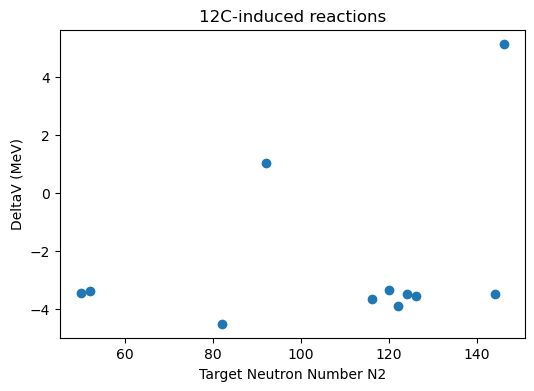

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(c12_df["N2"], c12_df["DeltaV"])
plt.xlabel("Target Neutron Number N2")
plt.ylabel("DeltaV (MeV)")
plt.title("12C-induced reactions")
plt.show()

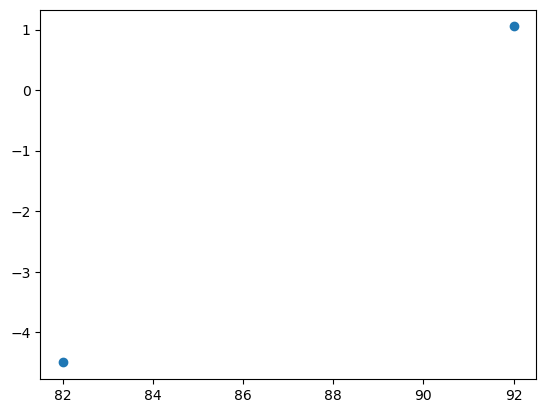

In [67]:
sm_df = c12_df[c12_df["Z2"] == 62]  # Sm
plt.plot(sm_df["N2"], sm_df["DeltaV"], marker='o')
plt.show()

In [68]:
switch_df.to_csv("switch_df_final.csv", index=False)
print("Saved switch_df_final.csv")

Saved switch_df_final.csv


In [69]:
barrier_df.to_csv("barrier_df.csv", index=False)

In [70]:
import numpy as np
import pandas as pd
import os

EN_DIR = "mdn_70_10_20_optimized/ensembles_fast"
N_COMPONENTS = 5
SEEDS = [42 + i for i in range(10)]

# Load original dataframe
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

all_pi = []

for s in SEEDS:
    seed_dir = os.path.join(EN_DIR, f"seed_{s}")
    data = np.load(os.path.join(seed_dir, "mdn_all_components.npz"))
    all_pi.append(data["pi"])

# Stack and average
all_pi = np.stack(all_pi, axis=0)  # (n_seeds, n_points, n_components)
pi_mean = all_pi.mean(axis=0)

# Create dataframe
pi_df = pd.DataFrame(pi_mean, columns=[f"pi_{k}" for k in range(N_COMPONENTS)])

# Add identifiers
pi_df["Reaction"] = df["Reaction"].values
pi_df["E c.m."] = df["E c.m."].values

# Save
pi_df.to_csv("pi_ensemble.csv", index=False)

print("Saved pi_ensemble.csv")

Saved pi_ensemble.csv


## Checking whather the switching coordinate is universal across the test and validation set or not

In [50]:
import pandas as pd
import numpy as np

OUTDIR_BASE = "mdn_70_10_20_optimized"

train_reacts = pd.read_csv(f"{OUTDIR_BASE}/train_reactions.csv")["Reaction"].values
val_reacts   = pd.read_csv(f"{OUTDIR_BASE}/val_reactions.csv")["Reaction"].values
test_reacts  = pd.read_csv(f"{OUTDIR_BASE}/test_reactions.csv")["Reaction"].values

In [51]:
switch_df["set"] = np.where(
    switch_df["Reaction"].isin(test_reacts),
    "test",
    "train"
)

print(switch_df.groupby("set")["x_switch"].describe())

       count      mean       std       min       25%       50%       75%  \
set                                                                        
test    37.0  0.924039  0.056699  0.837655  0.885577  0.905564  0.942254   
train  143.0  0.928477  0.051525  0.842207  0.888926  0.921453  0.951229   

            max  
set              
test   1.110090  
train  1.089706  


In [52]:
switch_df["set"] = np.select(
    [
        switch_df["Reaction"].isin(test_reacts),
        switch_df["Reaction"].isin(val_reacts)
    ],
    ["test", "val"],
    default="train"
)

print(switch_df.groupby("set")["x_switch"].describe())

       count      mean       std       min       25%       50%       75%  \
set                                                                        
test    37.0  0.924039  0.056699  0.837655  0.885577  0.905564  0.942254   
train  124.0  0.929740  0.051780  0.842207  0.889539  0.924344  0.952518   
val     19.0  0.920237  0.050390  0.873140  0.883808  0.900812  0.938439   

            max  
set              
test   1.110090  
train  1.089706  
val    1.073011  
